In [1]:
# Import Required Libraries
import os
import pickle
import pandas as pd
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, History
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from keras.layers import Dense, InputLayer, Dropout, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping as ES
from IPython.display import clear_output as cls


In [2]:
train_dir = "/kaggle/input/plant-leaf-disease-dataset/Plant_Diseases_Dataset/train"
test_dir = "/kaggle/input/plant-leaf-disease-dataset/Plant_Diseases_Dataset/valid"
class_names = sorted(os.listdir(train_dir))

In [3]:
image_shape = (300, 300)
batch_size = 32
epochs_initial = 10
epochs_fine_tune = 5
learning_rate_initial = 0.001
learning_rate_fine_tune = 0.0001


In [4]:
class_names = sorted(os.listdir(train_dir))
class_names

['Groundnut_early_leaf_spot',
 'Groundnut_early_rust',
 'Groundnut_healthy_leaf',
 'Groundnut_late_leaf_spot',
 'Groundnut_nutrition_deficiency',
 'Groundnut_rust',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites_Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy',
 'potato_early',
 'potato_healthy',
 'potato_late']

In [5]:
import os

class_wise_images = []
for name in class_names:
    path = os.path.join(train_dir, name)  # Proper path concatenation
    if os.path.exists(path):  # Check if the path exists
        class_wise_images.append(len(os.listdir(path)))


class_wise_images


[1322,
 1065,
 1462,
 1491,
 1255,
 1315,
 1702,
 1920,
 1848,
 1882,
 1745,
 1741,
 1827,
 1961,
 1790,
 1926,
 1998,
 2008,
 1998]

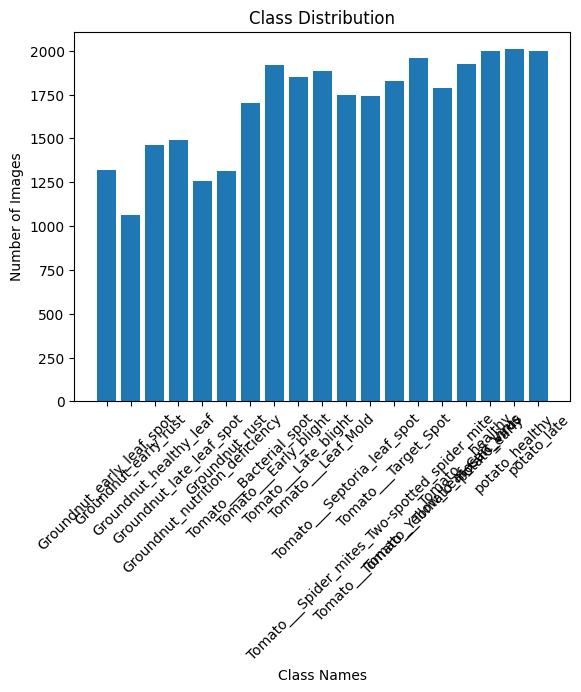

In [6]:
import matplotlib.pyplot as plt

plt.bar(class_names, class_wise_images)
plt.xlabel("Class Names")
plt.ylabel("Number of Images")
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()


In [7]:
import os
import plotly.express as px

# Function to count images per class from directory
def count_images_per_class(directory):
    class_names = sorted(os.listdir(directory))  # List class names
    images_per_class = {}
    for name in class_names:
        class_path = os.path.join(directory, name)  # Full path to the class folder
        if os.path.isdir(class_path):  # Check if it's a directory
            images_per_class[name] = len(os.listdir(class_path))  # Count images
        else:
            images_per_class[name] = 0  # If not a directory, count as 0
    return images_per_class

# Count images per class
images_per_class_train = count_images_per_class(train_dir)

# Extract class names and image counts
class_names = list(images_per_class_train.keys())  # Names of the classes
class_wise_images = list(images_per_class_train.values())  # Corresponding counts

# Create a pie chart
fig = px.pie(
    names=class_names,
    values=class_wise_images,
    title="Distribution of Classes"
)

# Update layout for better visualization
fig.update_layout(
    title={"text": "Distribution of Class", "x": 0.5},
    template="plotly_dark"  # Optional: Use a dark theme
)

# Display the chart
fig.show()


In [8]:
# Data Augmentation and Generators
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

In [9]:
val_gen = ImageDataGenerator(rescale=1./255)

In [10]:
train_ds = train_gen.flow_from_directory(
    train_dir, target_size=image_shape, batch_size=batch_size, subset='training', class_mode='categorical'
)

Found 25810 images belonging to 19 classes.


In [11]:
val_ds = train_gen.flow_from_directory(
    train_dir, target_size=image_shape, batch_size=batch_size, subset='validation', class_mode='categorical'
)

Found 6446 images belonging to 19 classes.


In [12]:
# Split Validation Data into Validation and Test Sets
filepaths = val_ds.filepaths
classes = val_ds.classes

X_val, X_test, y_val, y_test = train_test_split(
    filepaths, classes, test_size=0.5, stratify=classes, random_state=42
)

In [13]:
# Create DataFrames for Validation and Test Sets
val_df = pd.DataFrame({'filename': X_val, 'class': y_val})
test_df = pd.DataFrame({'filename': X_test, 'class': y_test})

In [14]:
# Create a mapping from class indices to class names
class_indices = {v: k for k, v in train_ds.class_indices.items()}

# Map integer class labels to class names in validation and test DataFrames
val_df['class'] = val_df['class'].map(class_indices)
test_df['class'] = test_df['class'].map(class_indices)

# Validation and Test Data Generators
val_ds = val_gen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical'
)

test_ds = val_gen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 3223 validated image filenames belonging to 19 classes.
Found 3223 validated image filenames belonging to 19 classes.


In [15]:
# Helper Function to Count Images per Class

def count_images_per_class(data_generator):
    # Get the class indices from the data generator
    class_indices = data_generator.class_indices
    # Invert the dictionary to map indices to class names
    class_indices = {v: k for k, v in class_indices.items()}
    # Initialize a dictionary to store the count of images per class
    images_per_class = {class_name: 0 for class_name in class_indices.values()}
    # Count the number of images per class
    for label in data_generator.classes:
        # Get the class name from the label index
        class_name = class_indices[label]
        images_per_class[class_name] += 1  # Increment the count for the class
    return images_per_class

In [16]:
# Assuming train_ds is your training data generator
images_per_class_train = count_images_per_class(train_ds)
print("Number of images per class in the training dataset:")
print(images_per_class_train)

Number of images per class in the training dataset:
{'Groundnut_early_leaf_spot': 1058, 'Groundnut_early_rust': 852, 'Groundnut_healthy_leaf': 1170, 'Groundnut_late_leaf_spot': 1193, 'Groundnut_nutrition_deficiency': 1004, 'Groundnut_rust': 1052, 'Tomato___Bacterial_spot': 1362, 'Tomato___Early_blight': 1536, 'Tomato___Late_blight': 1479, 'Tomato___Leaf_Mold': 1506, 'Tomato___Septoria_leaf_spot': 1396, 'Tomato___Spider_mites_Two-spotted_spider_mite': 1393, 'Tomato___Target_Spot': 1462, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 1569, 'Tomato___Tomato_mosaic_virus': 1432, 'Tomato___healthy': 1541, 'potato_early': 1599, 'potato_healthy': 1607, 'potato_late': 1599}


In [17]:
images_per_class_val = count_images_per_class(val_ds)
print("Number of images per class in the validation dataset:")
print(images_per_class_val)

Number of images per class in the validation dataset:
{'Groundnut_early_leaf_spot': 132, 'Groundnut_early_rust': 107, 'Groundnut_healthy_leaf': 146, 'Groundnut_late_leaf_spot': 149, 'Groundnut_nutrition_deficiency': 126, 'Groundnut_rust': 131, 'Tomato___Bacterial_spot': 170, 'Tomato___Early_blight': 192, 'Tomato___Late_blight': 184, 'Tomato___Leaf_Mold': 188, 'Tomato___Septoria_leaf_spot': 174, 'Tomato___Spider_mites_Two-spotted_spider_mite': 174, 'Tomato___Target_Spot': 183, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 196, 'Tomato___Tomato_mosaic_virus': 179, 'Tomato___healthy': 192, 'potato_early': 200, 'potato_healthy': 201, 'potato_late': 199}


In [18]:
def plot_images(data, class_names):
    
    r, c = 3, 4
    imgLen = r*c
    
    plt.figure(figsize=(20, 15))
    i = 1
    
    for images, labels in iter(data):
        id = np.random.randint(len(images))
        img = tf.expand_dims(images[id], axis=0)
        lab = class_names[np.argmax(labels[id])]
        
        plt.subplot(r, c, i)
        plt.imshow(img[0])
        plt.title(lab)
        plt.axis('off')
        cls()
        
        i+=1
        if i > imgLen:
            break
    plt.show()

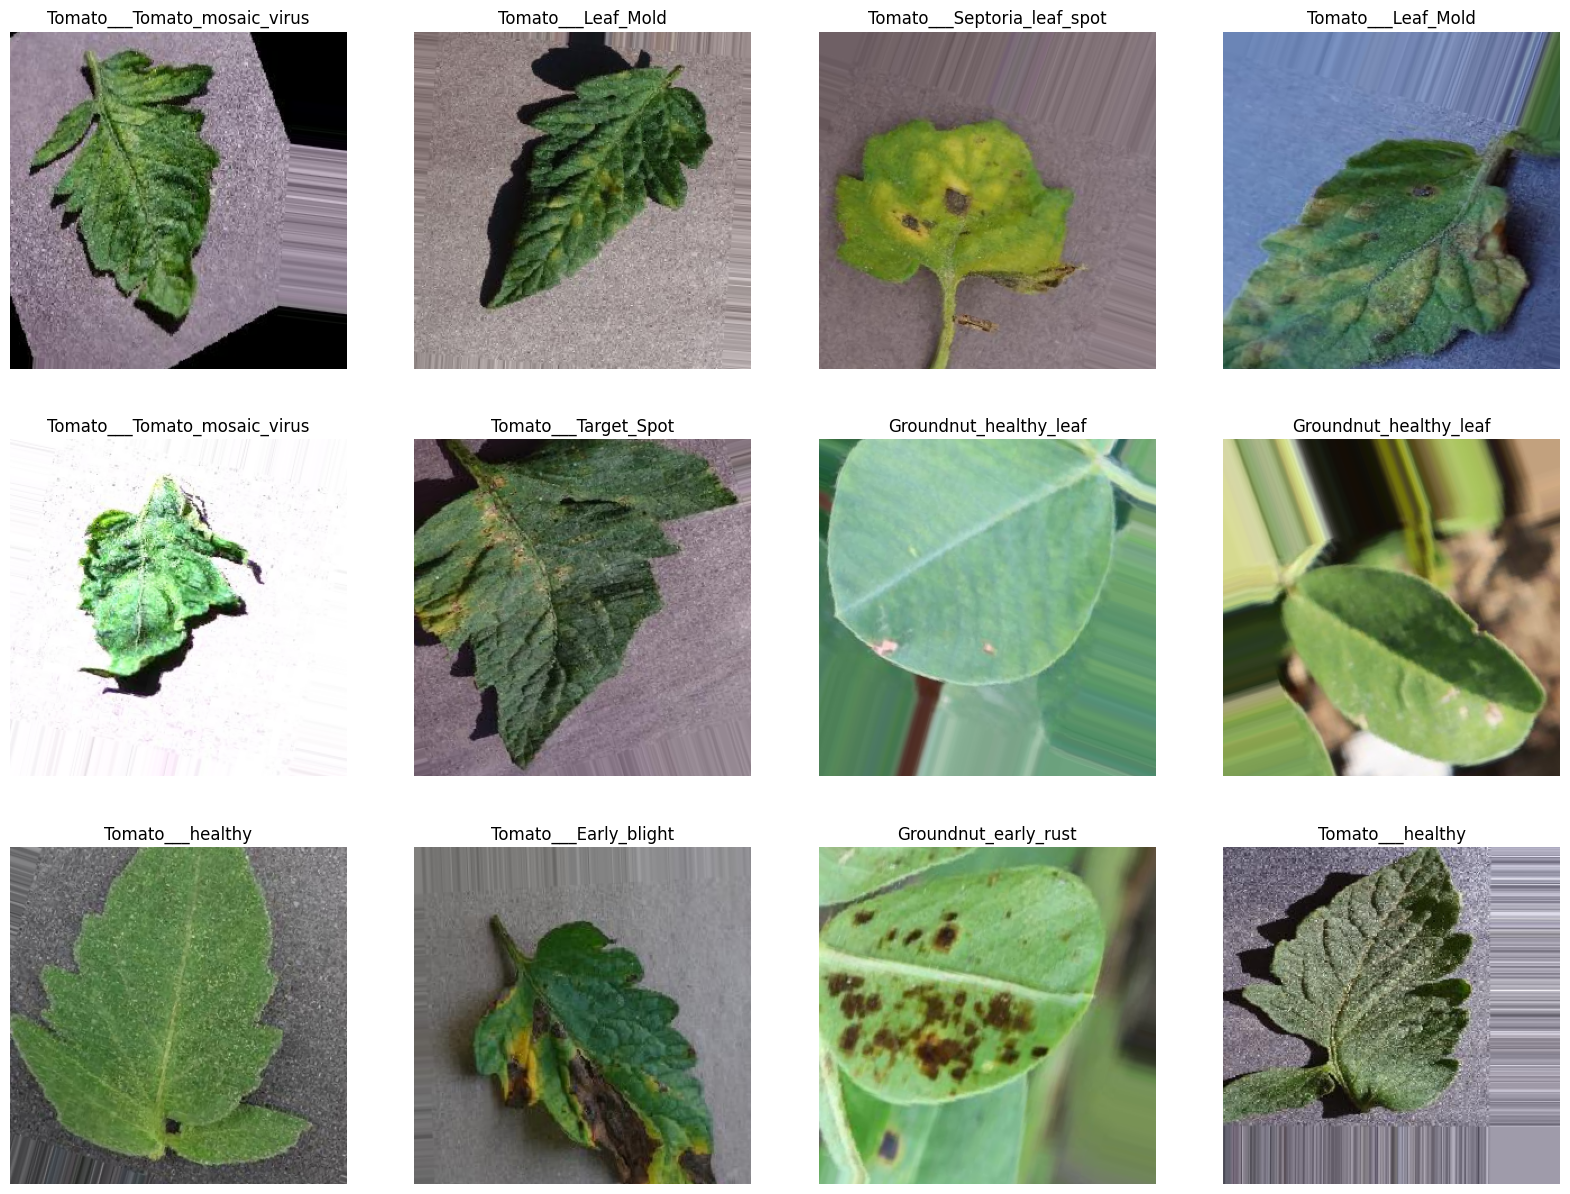

In [19]:
import numpy as np

import tensorflow as tf
plot_images(train_ds, class_names)


In [20]:
# EfficientNetB3 Model Building
def build_model():
    base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
    base_model.trainable = False  # Freeze base model layers

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    output = Dense(len(class_indices), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model


In [21]:
# Compile Model
model = build_model()
model.compile(optimizer=Adam(learning_rate=learning_rate_initial),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 300, 300, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 300, 300, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 300, 300, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 300, 300, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 301, 301, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 150, 150, 40)   │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 150, 150, 40)   │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 150, 150, 40)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 150, 150, 40)   │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 150, 150, 40)   │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 150, 150, 40)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 10,812,738 (41.25 MB)

 Trainable params: 29,203 (114.07 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [22]:
# Callbacks
checkpoint = ModelCheckpoint('efficientnetB3_initial_training.keras', save_best_only=True, monitor='val_accuracy')
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
history_callback = History()


In [23]:
# Initial Training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs_initial,
    callbacks=[checkpoint, early_stopping, history_callback]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



807/807 ━━━━━━━━━━━━━━━━━━━━ 636s 743ms/step - accuracy: 0.0578 - loss: 2.9752 - val_accuracy: 0.0540 - val_loss: 2.9478
Epoch 2/10
807/807 ━━━━━━━━━━━━━━━━━━━━ 503s 618ms/step - accuracy: 0.0615 - loss: 2.9675 - val_accuracy: 0.0580 - val_loss: 2.9245
Epoch 3/10
807/807 ━━━━━━━━━━━━━━━━━━━━ 511s 628ms/step - accuracy: 0.0592 - loss: 2.9646 - val_accuracy: 0.0776 - val_loss: 2.9400
Epoch 4/10
807/807 ━━━━━━━━━━━━━━━━━━━━ 511s 628ms/step - accuracy: 0.0591 - loss: 2.9694 - val_accuracy: 0.0726 - val_loss: 2.9322
Epoch 5/10
807/807 ━━━━━━━━━━━━━━━━━━━━ 515s 633ms/step - accuracy: 0.0643 - loss: 2.9630 - val_accuracy: 0.0596 - val_loss: 2.9095
Epoch 6/10
807/807 ━━━━━━━━━━━━━━━━━━━━ 514s 632ms/step - accuracy: 0.0648 - loss: 2.9591 - val_accuracy: 0.0915 - val_loss: 2.9245
Epoch 7/10
807/807 ━━━━━━━━━━━━━━━━━━━━ 512s 629ms/step - accuracy: 0.0644 - loss: 2.9647 - val_accuracy: 0.0856 - val_loss: 2.9091
Epoch 8/10
807/807 ━━━━━━━━━━━━━━━━━━━━ 505s 621ms/step - accuracy: 0.0650 - loss: 2.95

In [24]:
# Fine-Tuning
for layer in model.layers[-10:]:
    layer.trainable = True  # Unfreeze the last 10 layers for fine-tuning

model.compile(optimizer=Adam(learning_rate=learning_rate_fine_tune),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpoint_fine_tune = ModelCheckpoint('efficientnetB3_fine_tuning.keras', save_best_only=True, monitor='val_accuracy')

history_fine_tune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs_fine_tune,
    callbacks=[checkpoint_fine_tune, early_stopping, history_callback]
)



Epoch 1/5
807/807 ━━━━━━━━━━━━━━━━━━━━ 577s 673ms/step - accuracy: 0.0671 - loss: 2.9399 - val_accuracy: 0.0853 - val_loss: 2.8843
Epoch 2/5
807/807 ━━━━━━━━━━━━━━━━━━━━ 520s 638ms/step - accuracy: 0.0753 - loss: 2.9063 - val_accuracy: 0.1126 - val_loss: 2.8465
Epoch 3/5
807/807 ━━━━━━━━━━━━━━━━━━━━ 510s 627ms/step - accuracy: 0.0809 - loss: 2.8843 - val_accuracy: 0.0490 - val_loss: 2.9860
Epoch 4/5
807/807 ━━━━━━━━━━━━━━━━━━━━ 517s 635ms/step - accuracy: 0.0778 - loss: 2.8747 - val_accuracy: 0.0887 - val_loss: 2.7560
Epoch 5/5
807/807 ━━━━━━━━━━━━━━━━━━━━ 515s 633ms/step - accuracy: 0.0853 - loss: 2.8558 - val_accuracy: 0.0971 - val_loss: 2.8315


In [25]:
# Save the Final Model
model.save('efficientnetB3_final_model.h5')


In [26]:
# # Save Training History
# with open('training_EffcientAll__history.pkl', 'wb') as file:
#     pickle.dump(history_callback.history, file)


In [27]:
best_model = load_model('efficientnetB3_final_model.h5')

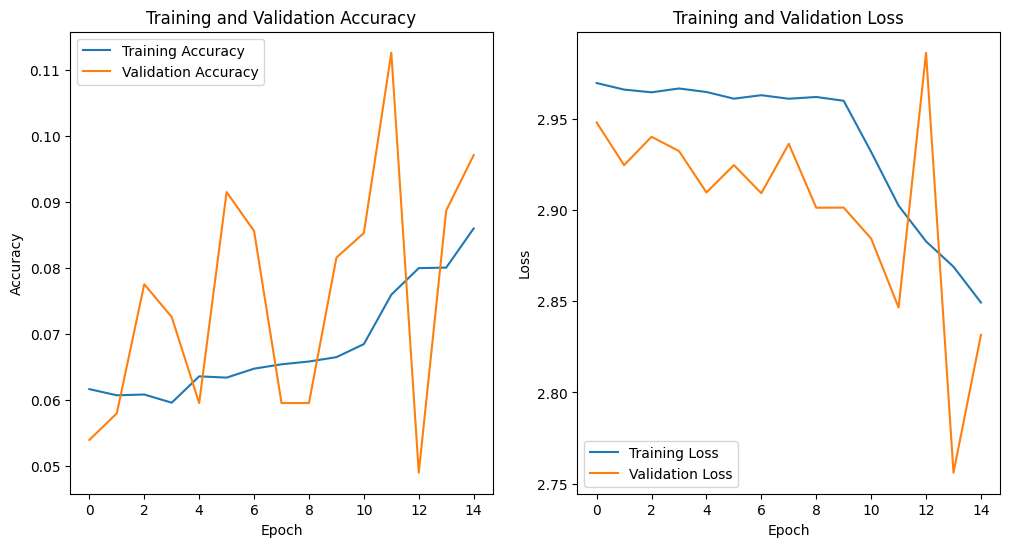

In [28]:
# Plot Training and Validation Metrics
def plot_metrics(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_metrics(history_callback.history)

In [29]:
# Evaluate on Test Data
best_model = load_model('efficientnetB3_final_model.h5')
test_loss, test_accuracy = best_model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.2f}")

101/101 ━━━━━━━━━━━━━━━━━━━━ 43s 352ms/step - accuracy: 0.0923 - loss: 2.7478
Test Accuracy: 0.09


In [30]:
# Save Training History
with open('training_EffcientAll__history.pkl', 'wb') as file:
    pickle.dump(history_callback.history, file)

In [ ]:
!zip -r output.zip /kaggle/working/